#Importing Libraries, Cleaning, Merging Datasets 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import umap

!pip install kmodes
from kmodes.kprototypes import KPrototypes

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [9]:
cities = pd.read_parquet('cities.parquet')
shops = pd.read_parquet('shops.parquet')
sales = pd.read_parquet('sales.parquet')

In [10]:
#Сразу же разберемся с отсутствующими данными в датасете shops, поскольку он будет основой для алгоритма кластеризации

shops.isna().sum()

shop_id                          0
neighborhood                     0
city                            57
year_opened                      0
is_on_the_road                   7
is_with_the_well                60
is_with_additional_services     61
shop_type                      132
dtype: int64

In [11]:
#Missing Data Percentage List

for col in shops.columns:
    pct_missing = np.mean(shops[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
print(pct_missing)

shop_id - 0.0%
neighborhood - 0.0%
city - 7.0%
year_opened - 0.0%
is_on_the_road - 1.0%
is_with_the_well - 7.0%
is_with_additional_services - 7.0%
shop_type - 16.0%
0.15621301775147928


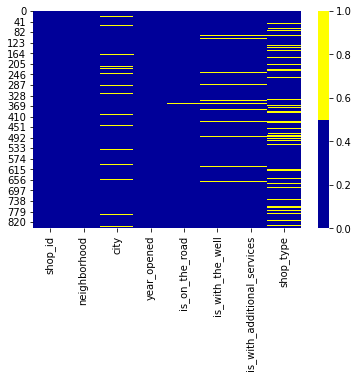

In [12]:
#Missing Data Heatmap

cols_shops = shops.columns[:] 
colours = ['#000099', '#ffff00'] # желтый цвет - отсутствующие данные, синий - имеющиеся.
sns.heatmap(shops[cols_shops].isnull(), cmap=sns.color_palette(colours))

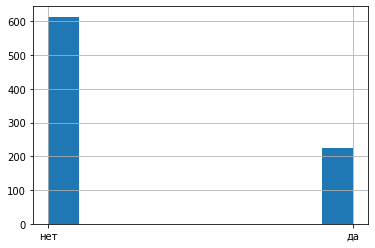

In [13]:
#is_on_the_road признак имеет всего лишь семь пропущенных значений, поэтому мы можем заместить их модой.

shops.is_on_the_road.hist()

shops['is_on_the_road'].fillna('нет', inplace=True)


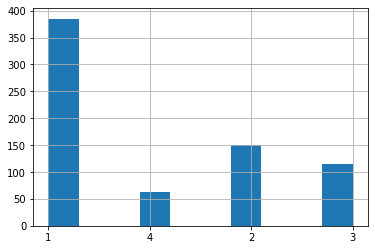

In [14]:
#Пропущенных значений признака shop_type больше всего, и удалив строки с проп. значениями, мы потеряем большую часть данных. 
#Я считаю, что лучше заменить пропущенные значения модой, чем потерять данные остальных признаков. Более того, первый тип сильно преобладает над остальными.

shops.shop_type.hist()

shops['shop_type'].fillna(1, inplace=True)

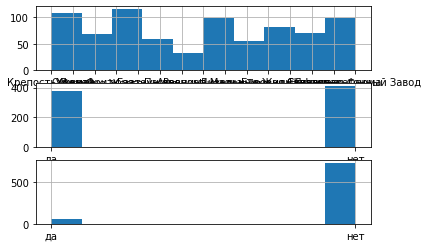

In [15]:
#Строки с пропущенными значениями признаков city и is_with_additional_services лучше удалить, так как нет ярко выраженной моды, а is_with_the_well очень сильно скошен в сторону 'нет', поэтому можно удалить весь признак.

plt.subplot(311)
shops['city'].hist()

plt.subplot(312)
shops['is_with_additional_services'].hist()

plt.subplot(313)
shops['is_with_the_well'].hist()

In [16]:
#В признаке is_with_the_well значения 'нет' составляют 93%

shops['is_with_the_well'].value_counts()
55/730

0.07534246575342465

In [17]:
del shops['is_with_the_well']

In [18]:
shops = shops.dropna()

In [19]:
#Проверяем сколько осталось магазинов после чистки датасета

len(shops['shop_id'].unique())

727

In [20]:
#Признак shop_type имел одно и то же значение в строковом и численном виде, поэтому заменяем int 1 на str

shops['shop_type'][shops['shop_type'] == 1] = '1'

In [21]:
shops['shop_type'].unique()

array(['1', '4', '2', '3'], dtype=object)

In [22]:
#Объединяем датасеты

cities_shops_merged = shops.merge(cities, on='city', how='outer')
df_merged = sales.merge(cities_shops_merged, on = 'shop_id', how = 'outer')

In [23]:
df_merged = df_merged.dropna()
len(df_merged['shop_id'].unique())

727

In [24]:
#Датасет не содержит дупликатов

df_merged.duplicated().sum()

0

# Take a look at data structure

In [25]:
df_merged.info() #Большинство признаков являются категориальными. Также есть признак date, который в дальнейшем можно будет преобразовать. Например, в дни недели.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4398284 entries, 0 to 4829887
Data columns (total 13 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   date                         datetime64[ns]
 1   shop_id                      int64         
 2   owner                        object        
 3   number_of_counters           int32         
 4   goods_type                   object        
 5   total_items_sold             float64       
 6   neighborhood                 object        
 7   city                         object        
 8   year_opened                  float64       
 9   is_on_the_road               object        
 10  is_with_additional_services  object        
 11  shop_type                    object        
 12  location                     object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(8)
memory usage: 453.0+ MB


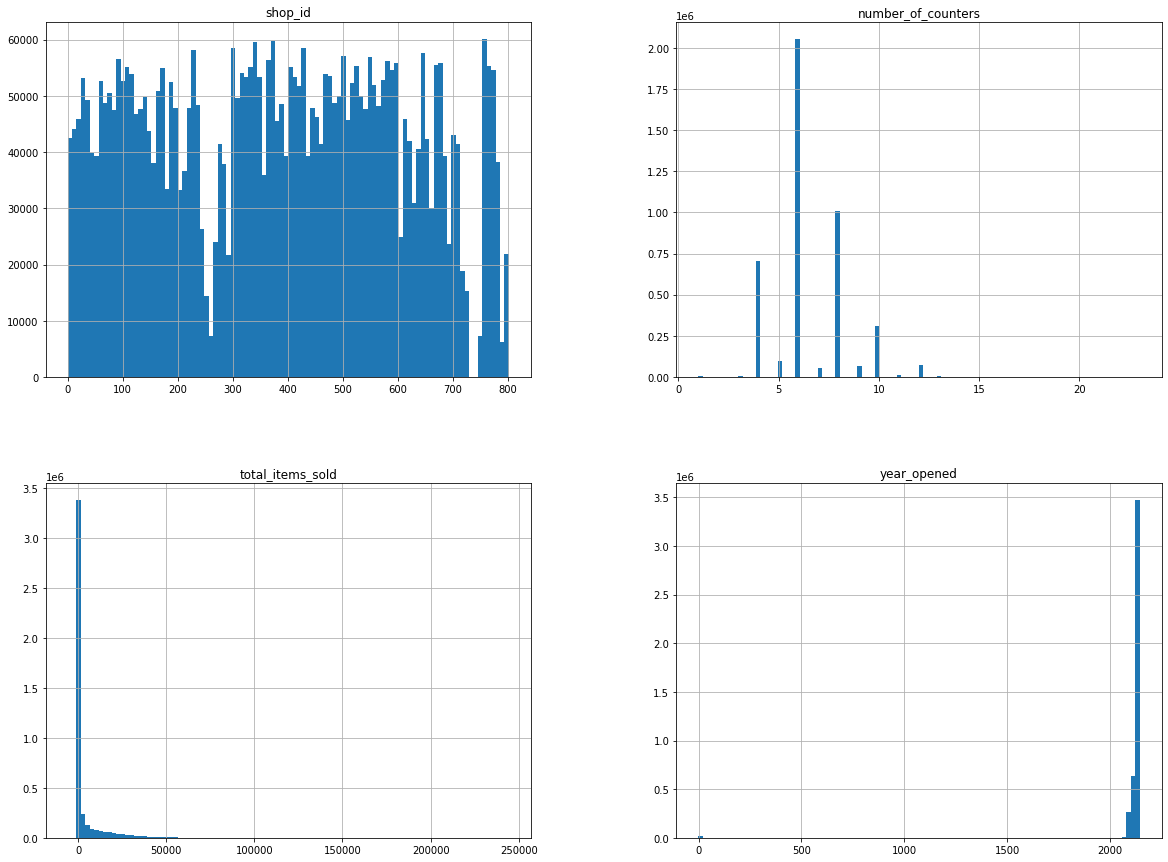

In [26]:
df_merged.hist(bins=100, figsize=(20,15))
plt.show() #number_of_counters и total_items_sold признаки смещены вправо, year_opened признак смещен влево. И похоже, что распредление признака total_items_sold далеко от нормального.

Looking for correlations

In [27]:
#Значимые корреляции численных признаков отсутствуют.

corr_matrix = df_merged.corr()
corr_matrix["total_items_sold"].sort_values(ascending=False)

total_items_sold      1.000000
number_of_counters    0.036753
shop_id               0.011668
year_opened           0.006366
Name: total_items_sold, dtype: float64

In [28]:
#year_opened признак сильно смещен. Я считаю, он не повлияет на дальнейший анализ, либо на принятие бизнес-решений. Этот признак можно удалить, чтобы он не влиял на кластеризацию.

del df_merged['year_opened']

In [29]:
#Переименую очищенный датасет

df_clean = df_merged




# Making Additional Feature

In [30]:
#Создаем столбец с днями недели

df_clean['day_of_week'] = pd.to_datetime(df_clean['date']).dt.day_name()

# Visualizing Data and Descriptive Statistics

Looking for goods_type insights

In [31]:
df_clean.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold,neighborhood,city,is_on_the_road,is_with_additional_services,shop_type,location,day_of_week
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0,В центре,Нефтеперегонный Завод,нет,нет,1,Свистящие Степи,Saturday
1,2146-01-01,0,Рейдеры,4,Хлам,26.0,В центре,Нефтеперегонный Завод,нет,нет,1,Свистящие Степи,Saturday
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0,В центре,Нефтеперегонный Завод,нет,нет,1,Свистящие Степи,Saturday
3,2146-01-02,0,Рейдеры,4,Съедобный хлам,3.0,В центре,Нефтеперегонный Завод,нет,нет,1,Свистящие Степи,Sunday
4,2146-01-02,0,Рейдеры,4,Хлам,5.0,В центре,Нефтеперегонный Завод,нет,нет,1,Свистящие Степи,Sunday


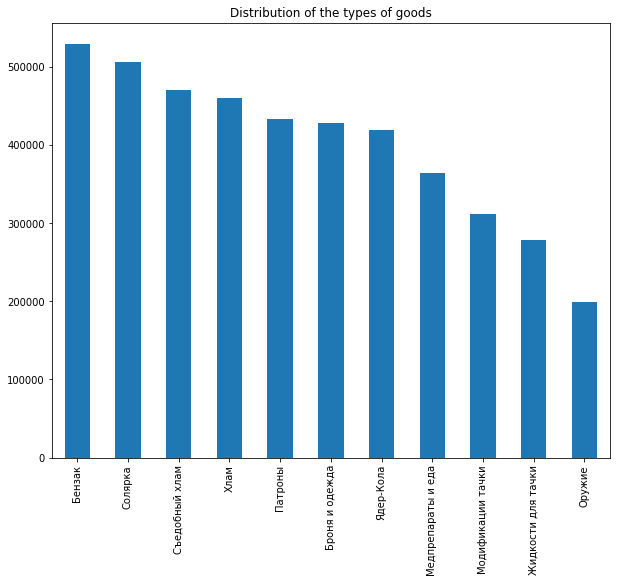

In [32]:
#Бензак и солярка продаются чаще остальных категорий. Оружие пользуется наименьшим спросом. Стоит посмотреть как кластеризуются основные источники дохода, то есть средние продажи самых популярных товаров, 
#а также как кластеризуется самый непродаваемый товар: возможно он укажет на наименее прибыльные кластеры

plt.figure(figsize=(10, 8))

df_clean['goods_type'].value_counts().plot.bar()
plt.title('Distribution of the types of goods')

plt.show()

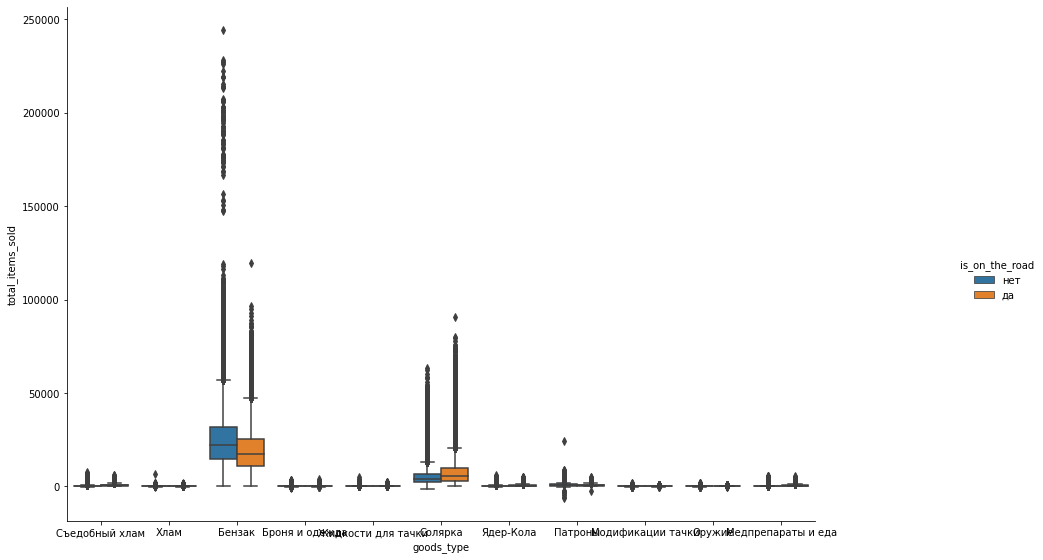

In [33]:
#Если магазин у дороги, то Бензак продается хуже, а Солярка лучше. Также можно заметить, что присутствует много выбросов.

g1 = sns.catplot(x="goods_type", y="total_items_sold", hue = 'is_on_the_road', kind="box", data=df_clean)

g1.fig.set_figwidth(16)
g1.fig.set_figheight(8)

Работа с выбросами

In [34]:
len(df_clean) #4398284 строк в датасете до очистки от экстремальных выбросов

4398284

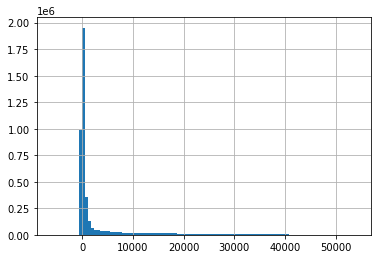

In [35]:
#Избавляемся от крайне экстремальных выбросов для лучшей визуализации и работы алгоритма кластеризации

std = df_clean['total_items_sold'].std()
df_clean = df_clean[df_clean['total_items_sold'] <= 6*std]
df_clean['total_items_sold'].hist(bins = 100)

In [37]:
len(df_clean) #17104 строк были выбросами

17104

Продолжение визуализации

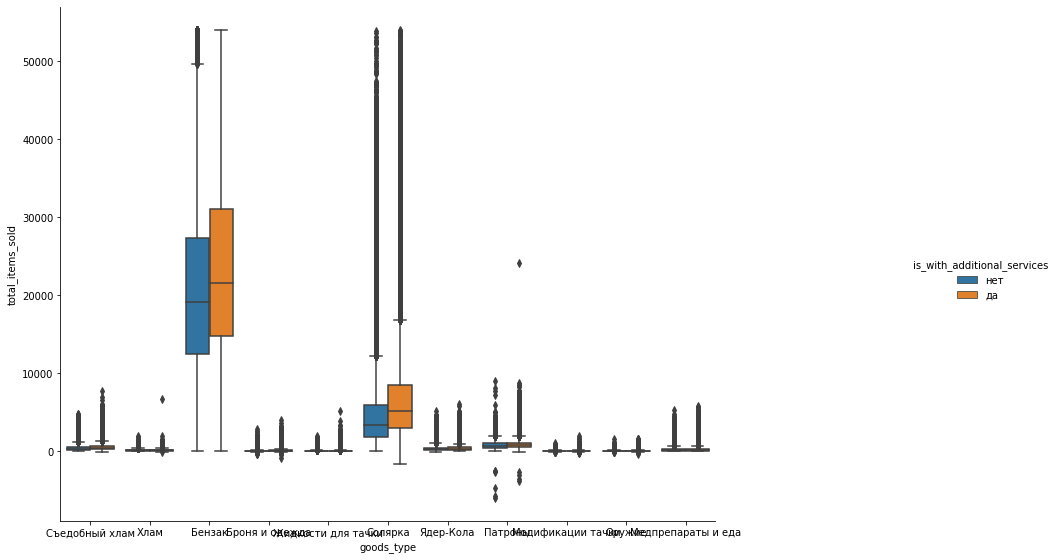

In [38]:
#Можно заметить, что наличие дополнительного сервиса вцелом увеличивает продажи по популярным категориям товаров.

g2 = sns.catplot(x="goods_type", y="total_items_sold", hue = 'is_with_additional_services', kind="box", data=df_clean)

g2.fig.set_figwidth(16)
g2.fig.set_figheight(8)

Looking for owner feature insights

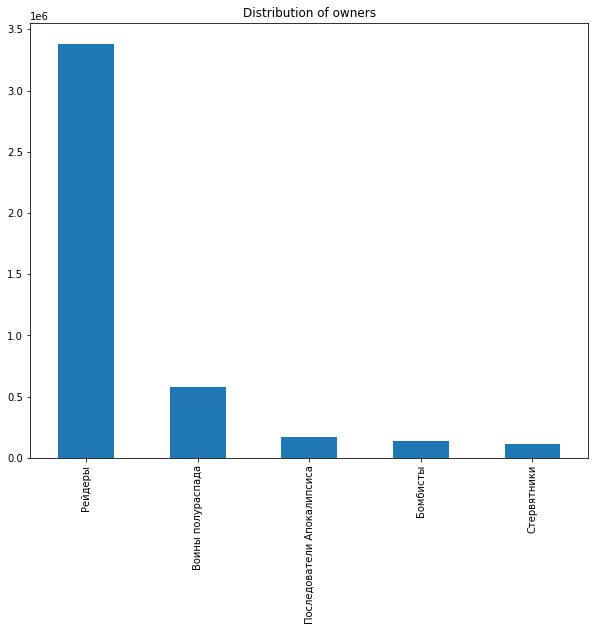

In [39]:
#Большинство владельцев - это рейдеры

plt.figure(figsize=(10, 8))

df_clean['owner'].value_counts().plot.bar()
plt.title('Distribution of owners')

plt.show()

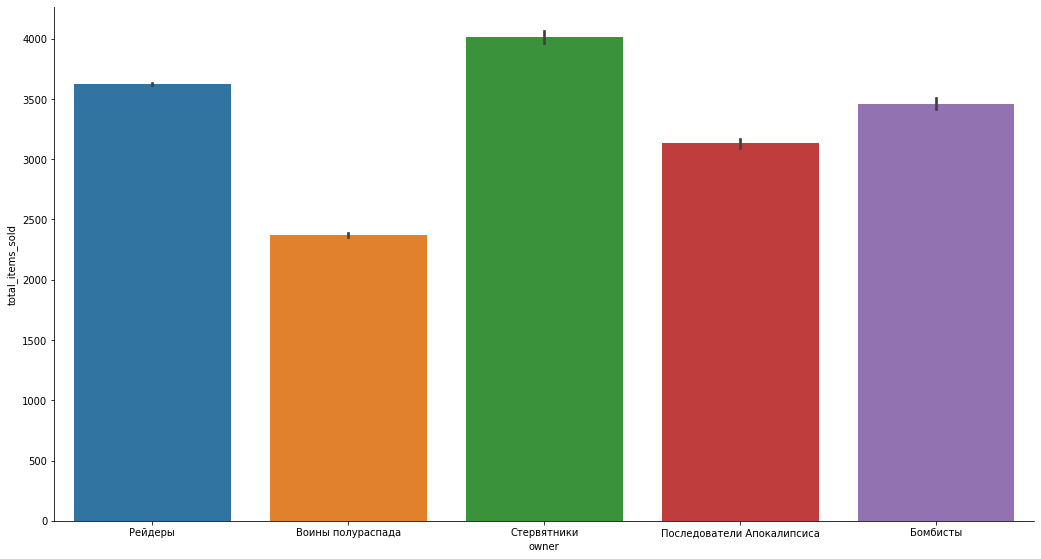

In [40]:
#Несмотря на то, что большиснтво владельцев - это рейдеры, продажи примерно одинаковы для всех владельцев. Стервятники слегка обходят рейдеров, а воины полураспада продают меньше остальных.

o1 = sns.catplot(x="owner", y="total_items_sold", kind="bar", data=df_clean)

o1.fig.set_figwidth(16)
o1.fig.set_figheight(8)

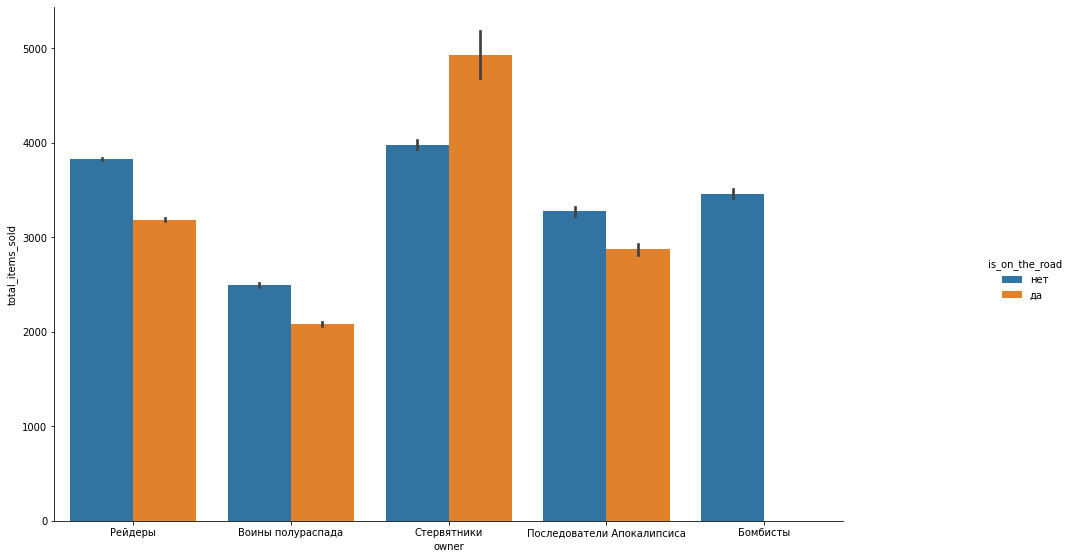

In [41]:
#Большинство владельцев совершают продажи в магазинах не у дороги.

o2 = sns.catplot(x="owner", y="total_items_sold", hue = 'is_on_the_road',
                 kind="bar", data=df_clean)

o2.fig.set_figwidth(16)
o2.fig.set_figheight(8)

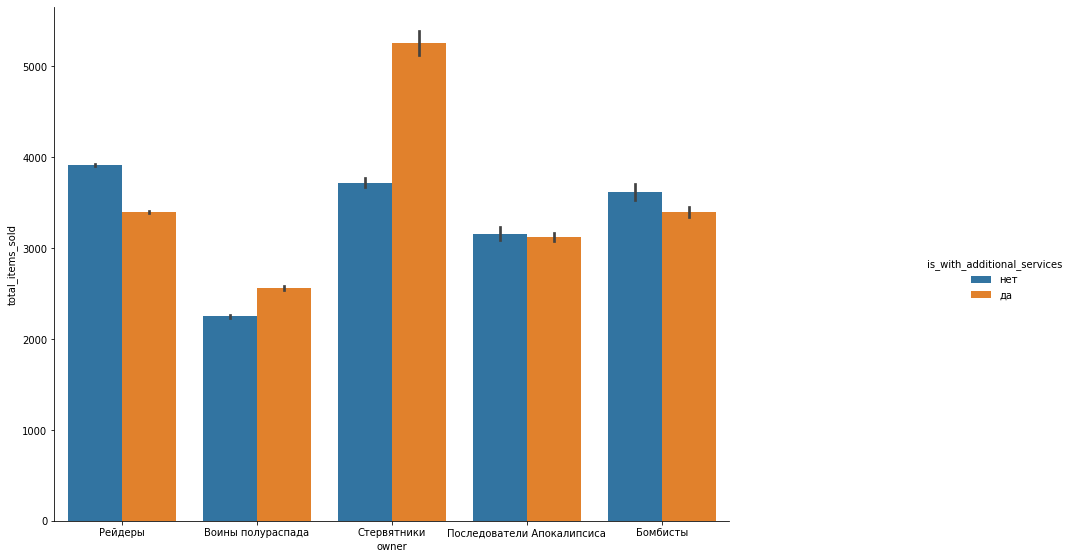

In [42]:
#Стервятники по сравнению с остальными получают значительную выгоду, имея доп сервис. Возможно, отчасти, доп сервис влияет на их первенство в продажах.

o3 = sns.catplot(x="owner", y="total_items_sold", hue = 'is_with_additional_services',
                 kind="bar", data=df_clean)

o3.fig.set_figwidth(16)
o3.fig.set_figheight(8)

Number of Counters and Total Items Sold Dependence

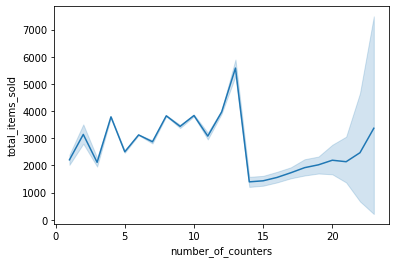

In [43]:
#Нет четкой связи между количеством прилавков и суммарными продажами, хотя есть небольшой тренд до 15 прилавков

sns.lineplot(x="number_of_counters", y="total_items_sold",
             data=df_clean)

Day of Week Visualization

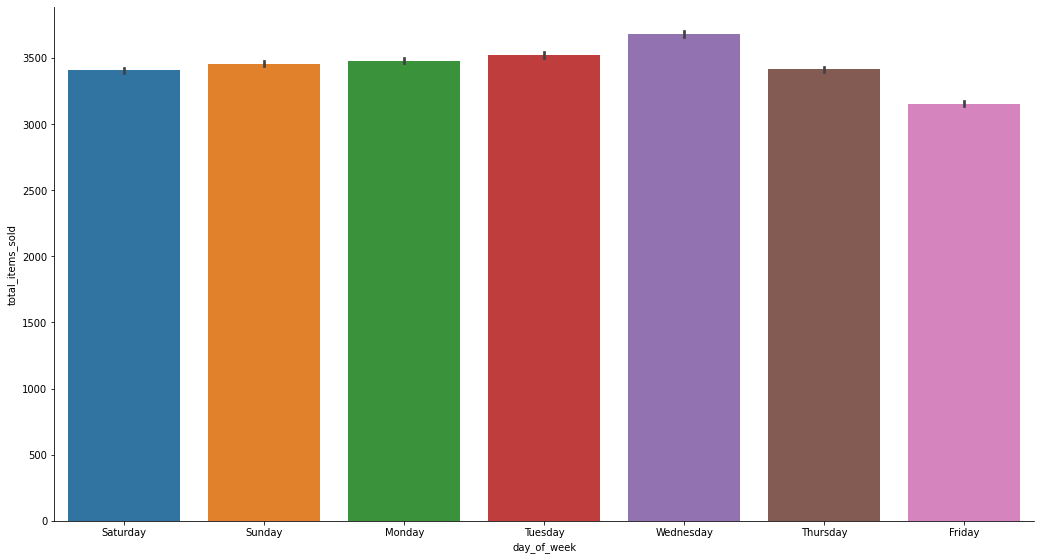

In [44]:
#Продажи примерно одинаковы для всех дней недели, хотя есть слабая растущая динамика, начинающаяся с пятницы. По аналогии с товарами стоит взять средние продажи по пятницам и средам.

we1 = sns.catplot(x="day_of_week", y="total_items_sold",
                 kind="bar", data=df_clean)

we1.fig.set_figwidth(16)
we1.fig.set_figheight(8)

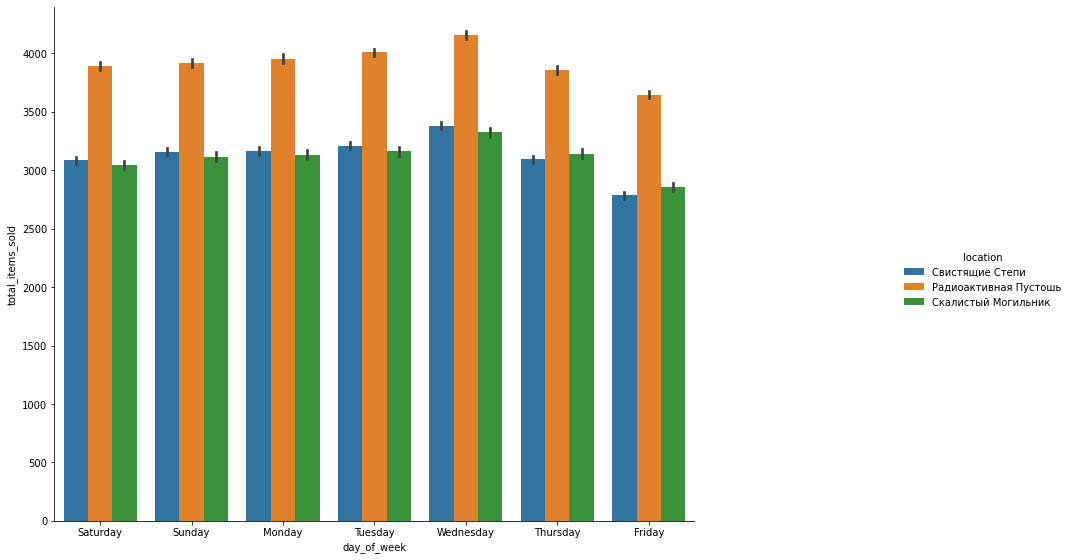

In [45]:
#В Радиактивной пустоши продажи самые высокие независимо от дня недели, хотя Степи и Могильник держатся близко и меняются местами в зависимости от дня недели. 

we2 = sns.catplot(x="day_of_week", y="total_items_sold", hue = 'location',
                 kind="bar", data=df_clean)

we2.fig.set_figwidth(16)
we2.fig.set_figheight(8)

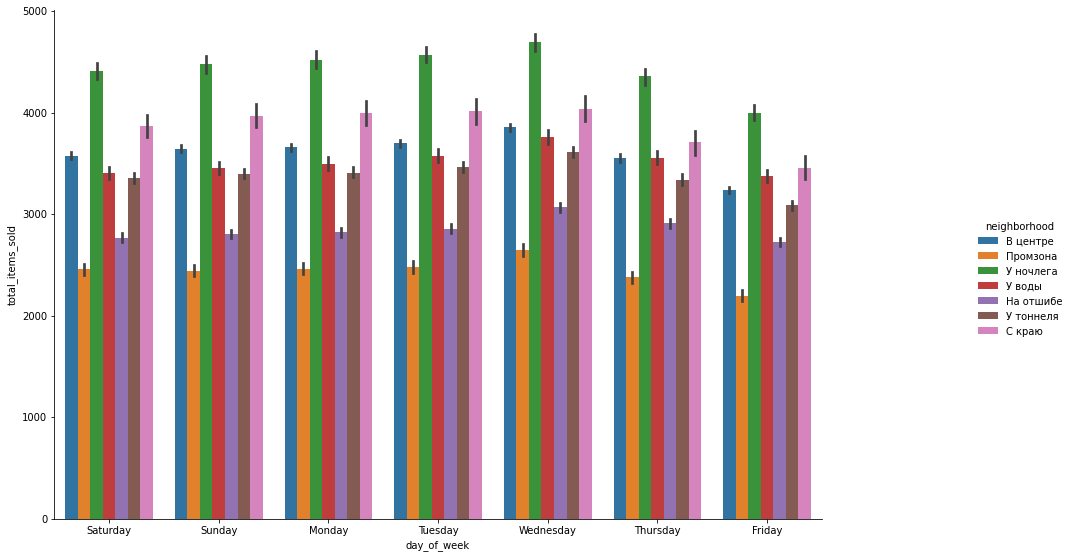

In [46]:
#Относительная конкуренция видна лишь В центре и У воды. Можно взять средние продажи в этих окрестностях.

we3 = sns.catplot(x="day_of_week", y="total_items_sold", hue = 'neighborhood',
                 kind="bar", data=df_clean)

we3.fig.set_figwidth(16)
we3.fig.set_figheight(8)

# Making More Additional Features and Merging




In [47]:
#Создадим переменные, показывающие средние продажи самых продающихся товаров и самого не продающегося, посмотрим на средние продажи магазинов по пятницам и средам, а также на средние продажи У воды и В центре

#Средние продажи Бензака
benz_avg_sales = df_clean[df_clean['goods_type'] == 'Бензак']

benz_avg_saless = benz_avg_sales.groupby(['shop_id'])['total_items_sold'].mean()

benz_avg = benz_avg_saless.to_frame().reset_index()

benz_avg.columns = ['shop_id', 'benz_avg_sales'] 

In [48]:
#Средние продажи Солярки
solar_avg_sales = df_clean[df_clean['goods_type'] == 'Солярка']

solar_avg_sales = solar_avg_sales.groupby(['shop_id'])['total_items_sold'].mean()

solar_avg = solar_avg_sales.to_frame().reset_index()

solar_avg.columns = ['shop_id', 'solar_avg_sales'] 

In [49]:
#Средние продажи Оружия
gun_avg_sales = df_clean[df_clean['goods_type'] == 'Оружие']

gun_avg_sales = gun_avg_sales.groupby(['shop_id'])['total_items_sold'].mean()

gun_avg = gun_avg_sales.to_frame().reset_index()

gun_avg.columns = ['shop_id', 'gun_avg_sales'] 

In [50]:
#Средние продажи по пятницам
friday_avg_sales = df_clean[df_clean['day_of_week'] == 'Friday']

friday_avg_sales = friday_avg_sales.groupby(['shop_id'])['total_items_sold'].mean()

friday_avg = friday_avg_sales.to_frame().reset_index()

friday_avg.columns = ['shop_id', 'friday_avg_sales'] 

In [57]:
#Средние продажи по средам
wednesday_avg_sales = df_clean[df_clean['day_of_week'] == 'Wednesday']

wednesday_avg_sales = wednesday_avg_sales.groupby(['shop_id'])['total_items_sold'].mean()

wednesday_avg = wednesday_avg_sales.to_frame().reset_index()

wednesday_avg.columns = ['shop_id', 'wednesday_avg_sales'] 

In [51]:
#Средние продажи по магазинам
avg_sales = df_clean.groupby(['shop_id'])['total_items_sold'].mean()

avg_sales = avg_sales.to_frame().reset_index()

avg_sales.columns = ['shop_id', 'avg_sales'] 

In [52]:
#Средние продажи в центре
center_avg_sales = df_clean[df_clean['neighborhood'] == 'В центре']

center_avg_sales = center_avg_sales.groupby(['shop_id'])['total_items_sold'].mean()

center_avg = center_avg_sales.to_frame().reset_index()

center_avg.columns = ['shop_id', 'center_avg'] 


In [53]:
#Средние продажи у воды
water_avg_sales = df_clean[df_clean['neighborhood'] == 'У воды']

water_avg_sales = water_avg_sales.groupby(['shop_id'])['total_items_sold'].mean()

water_avg = water_avg_sales.to_frame().reset_index()

water_avg.columns = ['shop_id', 'water_avg'] 



In [54]:
#Средние значения количества прилавков
nc_avg_sales = df_clean.groupby(['shop_id'])['number_of_counters'].mean()

nc_avg = nc_avg_sales.to_frame().reset_index()

nc_avg.columns = ['shop_id', 'nc_avg'] 

In [55]:
#Владельцы магазинов

shop_owner = df_clean.groupby(['shop_id'])['owner'].max()

shop_owner = shop_owner.to_frame().reset_index()

shop_owner.columns = ['shop_id', 'shop_owner']


In [58]:
#Добавляем все новые столбцы к датасету shops

dff = shops.merge(nc_avg, on = 'shop_id', how = 'left')
dff = dff.merge(water_avg, on = 'shop_id', how = 'left')
dff = dff.merge(center_avg, on = 'shop_id', how = 'left')
dff = dff.merge(avg_sales, on = 'shop_id', how = 'left')
dff = dff.merge(wednesday_avg, on = 'shop_id', how = 'left')
dff = dff.merge(friday_avg, on = 'shop_id', how = 'left')
dff = dff.merge(gun_avg, on = 'shop_id', how = 'left')
dff = dff.merge(solar_avg, on = 'shop_id', how = 'left')
dff = dff.merge(benz_avg, on = 'shop_id', how = 'left')
dff = dff.merge(shop_owner, on = 'shop_id', how = 'left')

In [59]:
del dff['year_opened']

In [60]:
dff.isna().sum()

shop_id                          0
neighborhood                     0
city                             0
is_on_the_road                   0
is_with_additional_services      0
shop_type                        0
nc_avg                           0
water_avg                      660
center_avg                     457
avg_sales                        0
wednesday_avg_sales              0
friday_avg_sales                 0
gun_avg_sales                  108
solar_avg_sales                 31
benz_avg_sales                   0
shop_owner                       0
dtype: int64

In [61]:
#Магазинов в центре и у воды оказалось слишком мало, эти признаки можно удалить

del dff['water_avg']
del dff['center_avg']

In [62]:
#Заполняем пропущенные значения средних продаж Соляры и Оружия для работы алгоритма

dff['gun_avg_sales'].fillna(dff['gun_avg_sales'].mean(), inplace=True)
dff['solar_avg_sales'].fillna(dff['solar_avg_sales'].mean(), inplace=True)

In [63]:
#Добавляем к нашему датасету колонку location

dff = dff.merge(cities, on = 'city', how = 'left')

In [64]:
#Теперь значимых корреляций гораздо больше

corr_matrixx = dff.corr()
corr_matrixx["avg_sales"].sort_values(ascending=False)

avg_sales              1.000000
wednesday_avg_sales    0.996052
friday_avg_sales       0.990859
benz_avg_sales         0.230578
gun_avg_sales          0.084949
shop_id                0.061281
solar_avg_sales        0.050301
nc_avg                -0.176990
Name: avg_sales, dtype: float64

In [65]:
#Итоговый датасет для анализа

dff.head()

,shop_id,neighborhood,city,is_on_the_road,is_with_additional_services,shop_type,nc_avg,avg_sales,wednesday_avg_sales,friday_avg_sales,gun_avg_sales,solar_avg_sales,benz_avg_sales,shop_owner,location
0,705,В центре,Крепость Джита,нет,да,1,7.997127,1532.798592,1223.645161,2785.915140,39.339207,3822.331499,48008.309735,Рейдеры,Скалистый Могильник
1,601,В центре,Суховей,нет,нет,4,4.993806,8544.006882,9671.456731,7420.444444,32.506006,1002.587017,16033.702332,Рейдеры,Скалистый Могильник
2,530,В центре,Храм Фритюра,нет,нет,1,5.987832,2265.758296,2477.468549,2048.093144,14.531746,1112.543956,14930.901235,Рейдеры,Скалистый Могильник
3,91,В центре,Убежище Жестянщика,нет,да,1,6.000000,2548.476314,2646.634653,2194.081818,15.830435,10534.189041,12242.861644,Рейдеры,Свистящие Степи
4,100,На отшибе,Убежище Жестянщика,да,да,2,5.969975,2315.094513,2721.877033,1918.283177,10.973262,3853.053498,16071.215364,Рейдеры,Свистящие Степи


# K-Prototypes Clustering

In [66]:
#Создаем копию датасета

kprot_data = dff.copy()

In [67]:
del kprot_data['shop_id']

Проекция на двумерное пространство

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/

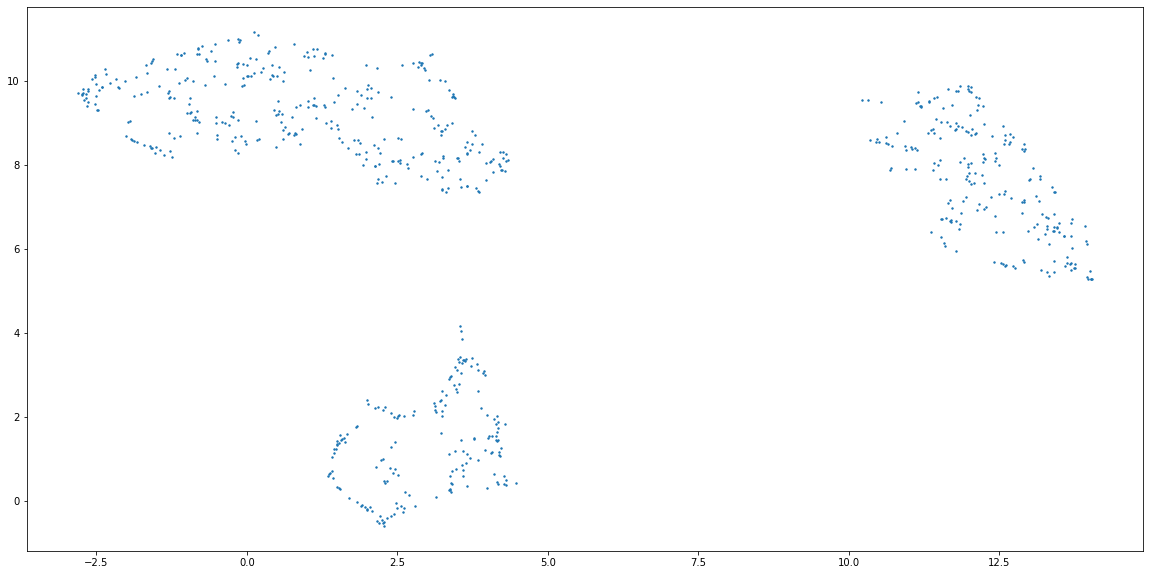

In [68]:
#Отображаем датасет на двумерное пространство, чтобы иметь примерное представление о количестве кластеров. 
#Используем алгоритм UMAP, так как итоговый датасет содержит много категориальных переменных

#Обработка численных данных
numerical = kprot_data.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
#Обработка категориальных данных
categorical = kprot_data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Процент категориальных колонок используется как вес. параметр для эмбеддинга
categorical_weight = len(kprot_data.select_dtypes(include='object').columns) / kprot_data.shape[1]

#Эмбеддинг
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)


intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

#Видно, что данные очень четко разбиваются на три участка

Алгоритм кластеризации K-Prototypes

In [69]:
#Я использую K-Prototypes, так как он способен работать с численными и категореальными признаками одновременно
#Для работы K-Means потребовалось бы one-hot-энкодить категориальные данные, что раздуло бы датасет и усложнило задачу кластеризации


#Предобработка
for c in kprot_data.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

categorical_columns = [0, 1, 2, 3, 4, 12, 13] #make sure to specify correct indices

#Кластеризация
kproto = KPrototypes(n_clusters= 3, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

#Количество объектов в каждом кластере
pd.Series(clusters).value_counts()

#Объекты разделились по кластерам 1 и 2 достаточно равномерно, в то же время в 0 кластере  достаточно много магазинов для образования кластера

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


2    278
1    273
0    176
dtype: int64

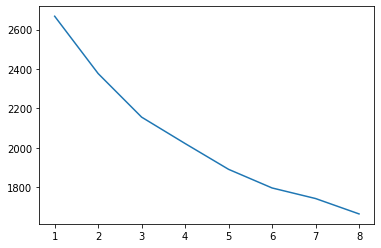

In [70]:
#Функция потерь методом локтя, на которой видно, что спад после трех кластеров замедляется
#Я считаю, что 3 это оптимальное число для количество кластеров

cost = []
for num_clusters in list(range(2,10)):
    kprotot = KPrototypes(n_clusters=num_clusters, init = "Cao", n_init = 3, n_jobs=4)
    kprotot.fit_predict(kprot_data, categorical=categorical_columns)
    cost.append(kprotot.cost_)

y = np.array([i for i in range(1,9,1)])
plt.plot(y,cost)

Визуальная оценка

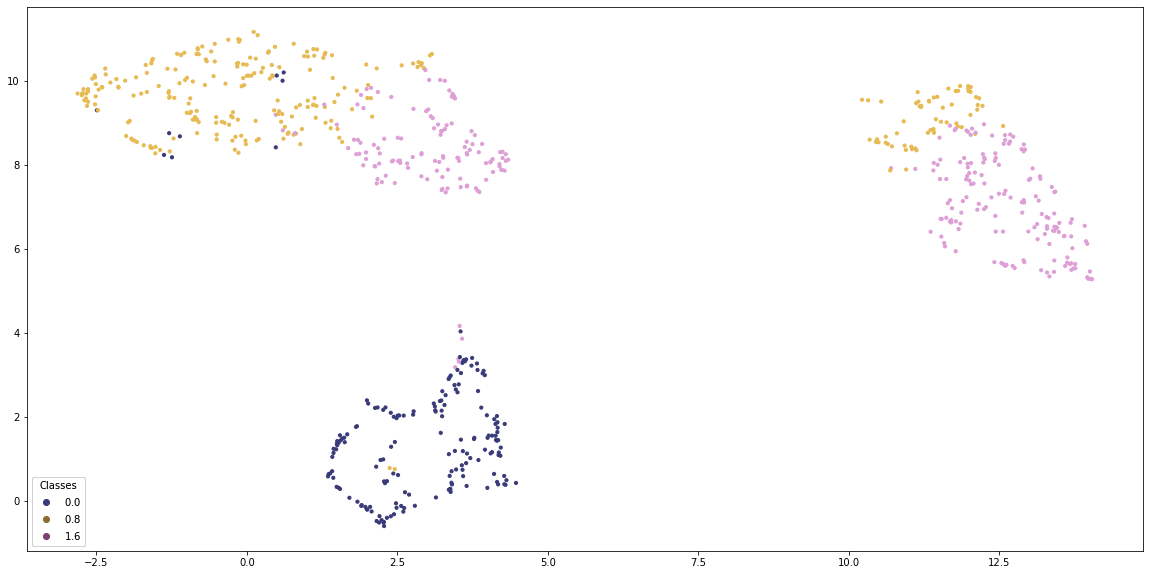

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=10, c=clusters, cmap='tab20b', alpha=1.0)


legend1 = ax.legend(*scatter.legend_elements(num=3),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

#Похоже, что нижний кластер достаточно однороден, верхние кластеры поделены двумя классами, хотя в каждом из них заметно преобладание одного класса.

Оценка с помощью классификации

In [72]:
#Я хочу попробовать посмотреть на кластеры как на лэйблы и использовать алгоритм классификации. Если кластеры качественные, то предсказания модели должны иметь высокую точность.
#Использую LightGBM классификатор, так как он способен работать с категориальными данными и легко показывает значимасть признаков для классификации

lgbm_data = kprot_data.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [73]:
#Точность модели достаточно высокая - F1 мера равна 0.96

clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.9656606745142622


In [74]:
cluster_dict = []
for c in clusters:
  cluster_dict.append(c)

In [100]:
dff['cluster_id'] = cluster_dict

Экспорт Tsv

In [111]:
import csv

with open('final_tsv', "w", newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter='\t')
        for line in zip(dff.shop_id.values, dff.cluster_id.values):
            writer.writerow(line)

# Cluster Analysis

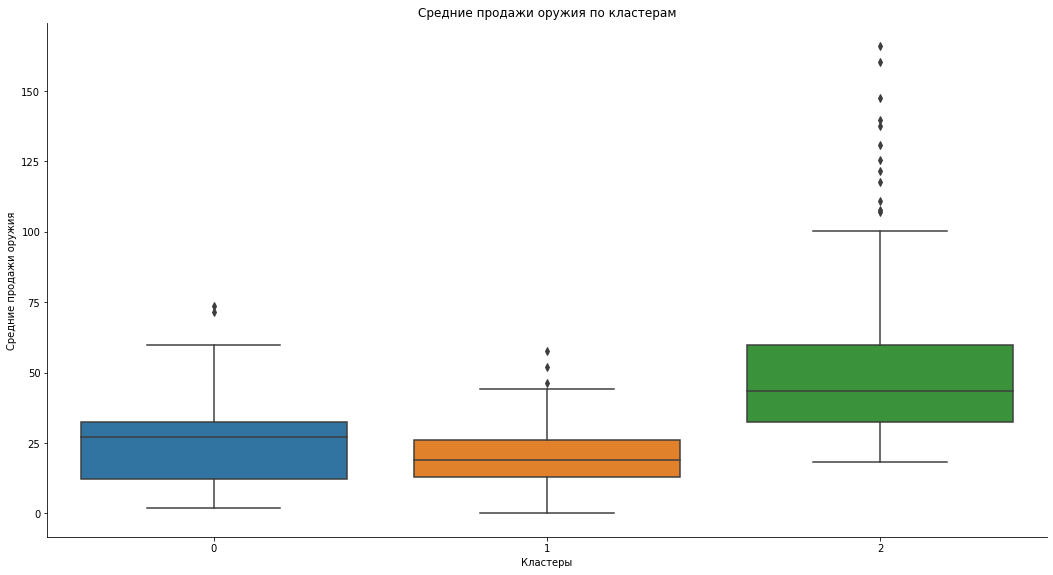

In [80]:
cluster_gun_vis = sns.catplot(x="cluster_id", y="gun_avg_sales", kind="box", data=dff)
plt.title('Средние продажи оружия по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Средние продажи оружия')

cluster_gun_vis.fig.set_figwidth(16)
cluster_gun_vis.fig.set_figheight(8)

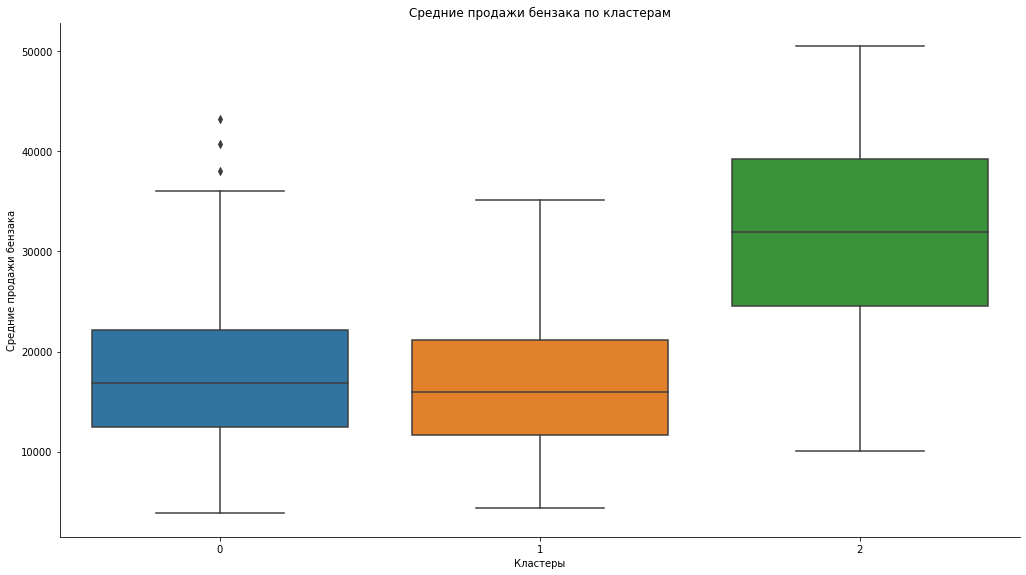

In [81]:
cluster_benz_vis = sns.catplot(x="cluster_id", y="benz_avg_sales", kind="box", data=dff)
plt.title('Средние продажи бензака по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Средние продажи бензака')

cluster_benz_vis.fig.set_figwidth(16)
cluster_benz_vis.fig.set_figheight(8)

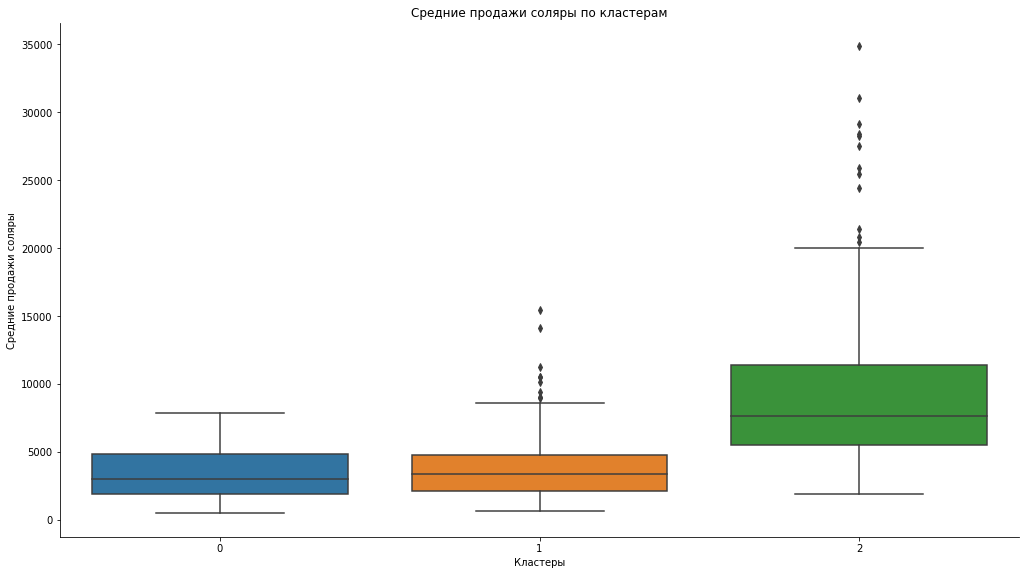

In [82]:
cluster_solar_vis = sns.catplot(x="cluster_id", y="solar_avg_sales", kind="box", data=dff)
plt.title('Средние продажи соляры по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Средние продажи соляры')

cluster_solar_vis.fig.set_figwidth(16)
cluster_solar_vis.fig.set_figheight(8)

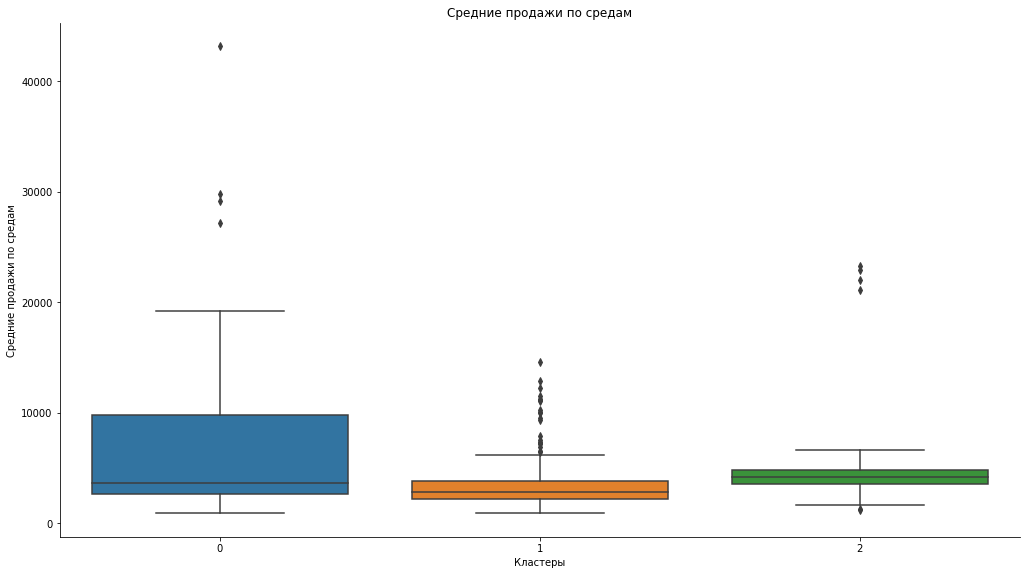

In [83]:
cluster_wed_vis = sns.catplot(x="cluster_id", y="wednesday_avg_sales", kind="box", data=dff)
plt.title('Средние продажи по средам')
plt.xlabel('Кластеры')
plt.ylabel('Средние продажи по средам')

cluster_wed_vis.fig.set_figwidth(16)
cluster_wed_vis.fig.set_figheight(8)

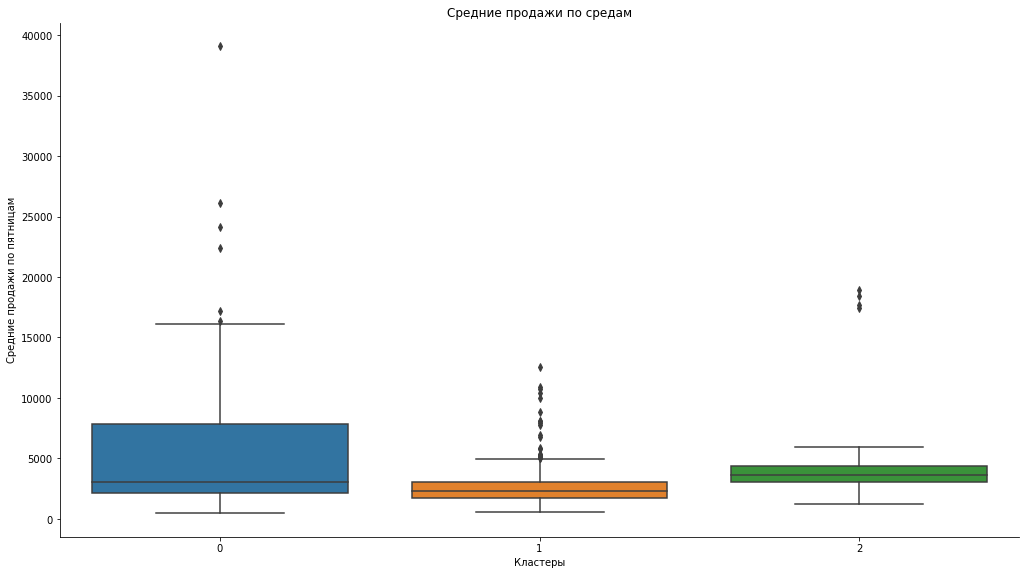

In [84]:
cluster_fri_vis = sns.catplot(x="cluster_id", y="friday_avg_sales", kind="box", data=dff)
plt.title('Средние продажи по средам')
plt.xlabel('Кластеры')
plt.ylabel('Средние продажи по пятницам')

cluster_fri_vis.fig.set_figwidth(16)
cluster_fri_vis.fig.set_figheight(8)

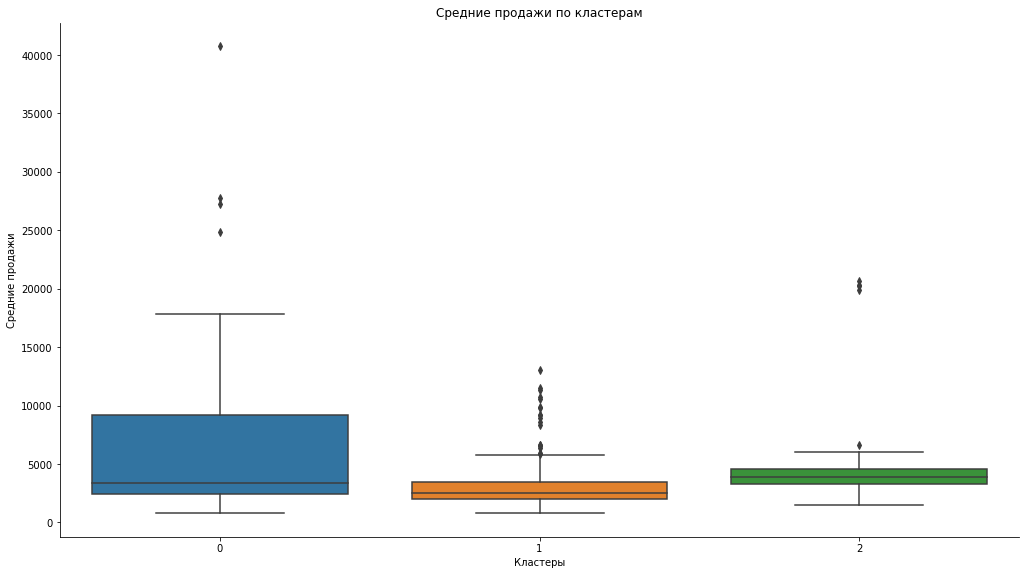

In [103]:
cluster_avg_vis = sns.catplot(x="cluster_id", y="avg_sales", kind="box", data=dff)
plt.title('Средние продажи по кластерам')
plt.xlabel('Кластеры')
plt.ylabel('Средние продажи')

cluster_avg_vis.fig.set_figwidth(16)
cluster_avg_vis.fig.set_figheight(8)

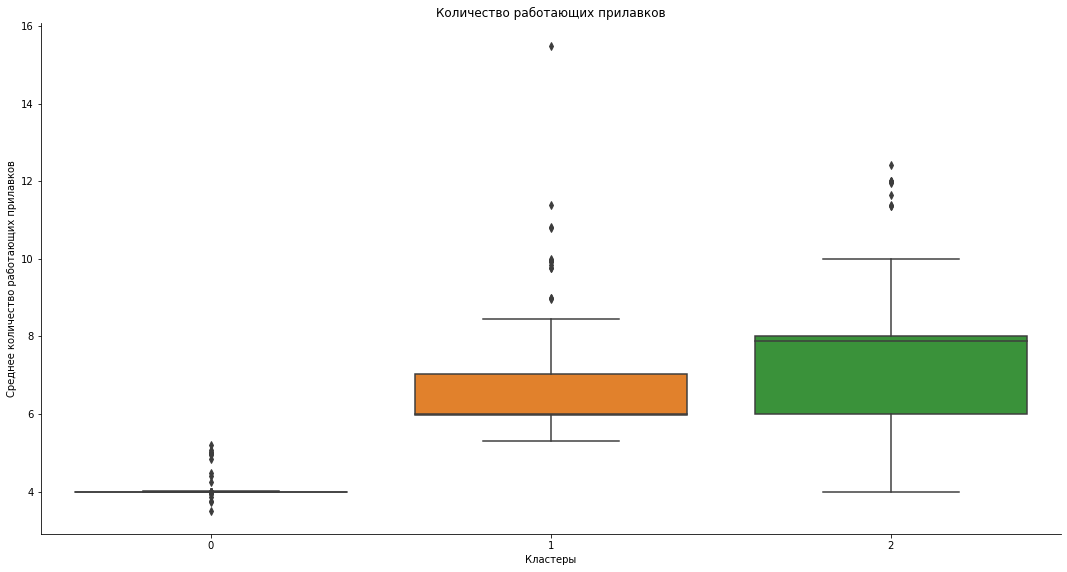

In [98]:
cluster_ncavg_vis = sns.catplot(x="cluster_id", y="nc_avg", kind="box", data=dff)
plt.title('Количество работающих прилавков')
plt.xlabel('Кластеры')
plt.ylabel('Среднее количество работающих прилавков')

cluster_ncavg_vis.fig.set_figwidth(16)
cluster_ncavg_vis.fig.set_figheight(8)

Похоже, что второй кластер оказался самым прибыльным по продажам Соляры, Бензака и Оружия, и по продажам вцелом. Нулевой и первый кластер достаточно близки по продажам, хотя нулевой кластер слегка опережает первый.

Пока из средних продаж по категориям товаров не ясно, в чем разница между нулевым и первым кластером, стоит взглянуть на другие признаки.

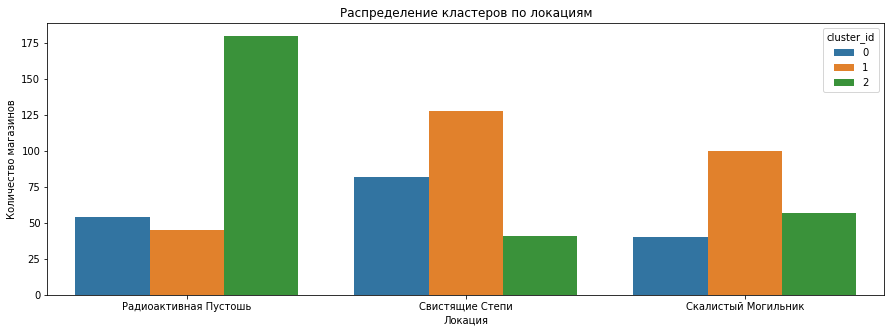

In [104]:
plt.subplots(figsize = (15,5))
sns.countplot(x=dff['location'],order=dff['location'].value_counts().index,hue=dff['cluster_id'])
plt.title('Распределение кластеров по локациям')
plt.xlabel('Локация')
plt.ylabel('Количество магазинов')

plt.show()

#Видно, что магазины самого прибыльного кластера доминируют в Радиоактивной Пустоши, в то  время как нулевой и первый кластер делят между собой Свистящие СТепи и Скалистый Могильник. Похоже, что Радиоактивная Пустошь является предпочтительной локацией для расположения магазина.

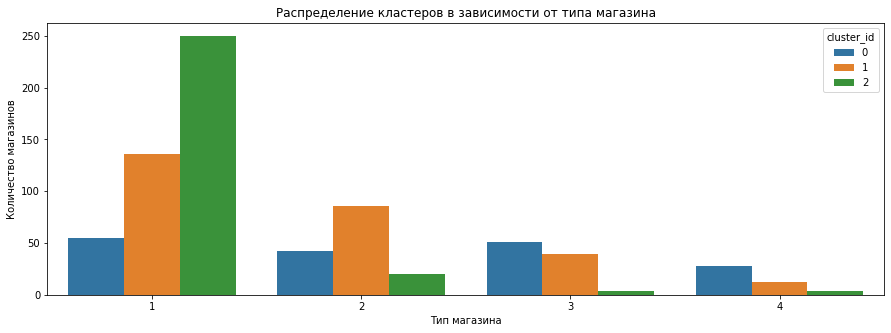

In [107]:
plt.subplots(figsize = (15,5))
sns.countplot(x=dff['shop_type'],order=dff['shop_type'].value_counts().index,hue=dff['cluster_id'])
plt.title('Распределение кластеров в зависимости от типа магазина')
plt.xlabel('Тип магазина')
plt.ylabel('Количество магазинов')
plt.show()

#Также видно, что магазины второго кластера - это магазины в основном первого типа. Первый кластер, наименее прибыльный, преобладает в количестве магазинов второго типа по сравнению с остальными, а нулевой кластер распределен примерно одинаково по всем типа магазинов.
#Это может указывать на то, что магазины первого типа более прибыльны чем магазины второго типа.

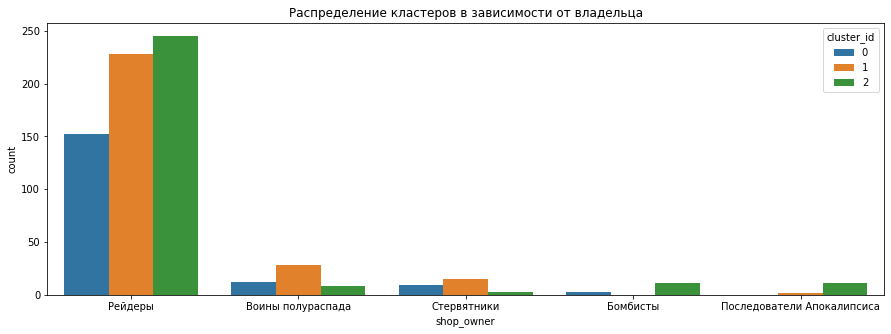

In [106]:
plt.subplots(figsize = (15,5))
sns.countplot(x=dff['shop_owner'],order=dff['shop_owner'].value_counts().index,hue=dff['cluster_id'])
plt.title('Распределение кластеров в зависимости от владельца')
plt.show()

#Большинство владельцев рейдеры и не похоже на то, что можно сделать какие-то значимые выводы относительно владельцев магазинов.

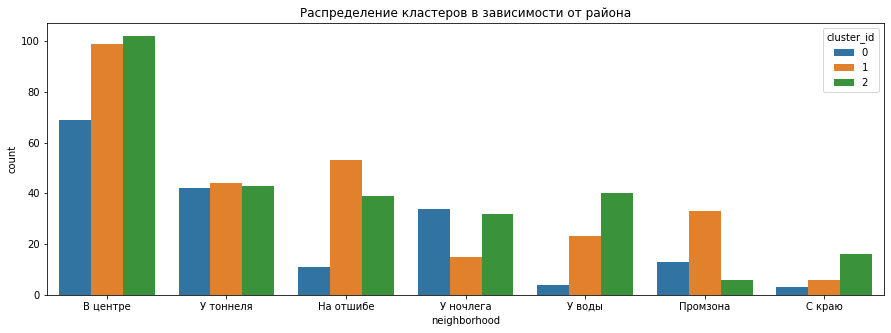

In [105]:
plt.subplots(figsize = (15,5))
sns.countplot(x=dff['neighborhood'],order=dff['neighborhood'].value_counts().index,hue=dff['cluster_id'])
plt.title('Распределение кластеров в зависимости от района')
plt.show()

#Второй кластер преобладает в центре, у воды и с краю. Возможно, это самые выгодные районы для расположения магазинов. Первый кластер преобладает на отшибе, у тоннеля и в значительной мере в промзоне. Видимо, это не лучшие места для установки магазина.

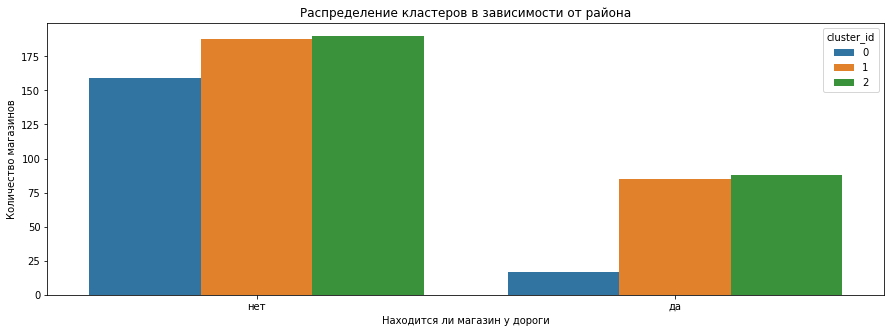

In [108]:
plt.subplots(figsize = (15,5))
sns.countplot(x=dff['is_on_the_road'],order=dff['is_on_the_road'].value_counts().index,hue=dff['cluster_id'])
plt.title('Распределение кластеров в зависимости от района')
plt.xlabel('Находится ли магазин у дороги')
plt.ylabel('Количество магазинов')
plt.show()

#Большинство магазинов не у дороги, и не похоже, что этот признак может сильно влиять на характеристики кластеров

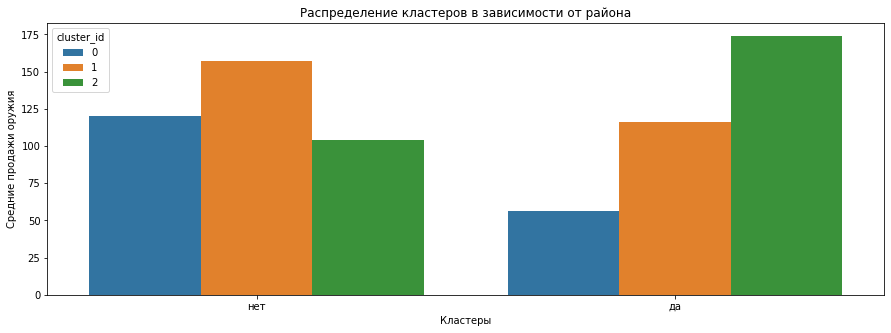

In [109]:
plt.subplots(figsize = (15,5))
sns.countplot(x=dff['is_with_additional_services'],order=dff['is_with_additional_services'].value_counts().index,hue=dff['cluster_id'])
plt.title('Распределение кластеров в зависимости от района')
plt.xlabel('Кластеры')
plt.ylabel('Средние продажи оружия')
plt.show()

#Видно, что наличие доп сервися коррелирует с кластерами: самый прибыльный кластре в основном имеет доп сервис, особенно в сравнении с первым кластером, у большинства магазинов которого не имеется доп сервиса

Характеристика кластеров

**Второй Кластер**: Является кластером, который сосредотачивает в себе самые прибыльные магазины. Он обходит другие кластеры по средним продажам самых прибыльных товаров, самого не прибыльного товара, по средним продажам в среду, самый прибыльный день, и в пятницу, самый неприбыльный день. Этот кластер имеет следующие отличительные черты: 

1.   Он значительно обходит другие кластеры по количеству магазинов с доп сервисом
2.   Он опережает другие кластеры по количеству магазинов в центре, и в значительной мере у воды
3.   Магазины этого кластера доминируют в Радиоактивной Пустоши
4.   Магазины второго кластера опережают остальных по количеству магазинов первого типа

Первый и Нулевой кластеры очень схожи по параметрам средних продаж, хотя Нулевой кластер обгоняет первый по продажам самых прибыльных товаров, и по средним продажам вцелом. Средние продажи не является ключевой характеристикой для дифференциации этих кластеров.
Магазинов нулевого кластера оказалось меньше, чем магазинов первого кластера на 97, поэтому по блольшинству категориальных характеристик первый класс опержает нулевой, но тем не менее нулевой кластер выгоднее первого. Нулевой кластер выигрывает по количеству магазинов 3 и 4 типа, а также он выигрывает первый кластер по количеству магазинов в Радиоактивной Пустоши. Возможно, признаки shop_type и location влияют на продажи сильнее остальных и поэтому позволяют магазинам нулевого кластера выигрывать магазины первого кластера по средним продажам.

